In [153]:
import pandas as pd
df = pd.read_csv('/Users/nickhausman/Desktop/DATA/DATA_403_Project_2/cleaned_training_data.csv')
bb = pd.read_csv('/Users/nickhausman/Desktop/DATA/P2/home-credit-default-risk/bureau_balance.csv')
b = pd.read_csv('/Users/nickhausman/Desktop/DATA/P2/home-credit-default-risk/bureau.csv')
df.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT,HOUSING_SCORE
0,0,100002,1,Cash loans,M,N,Y,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,1,0.0
1,8,100016,0,Cash loans,F,N,Y,67500.0,80865.0,5881.5,...,0,0,0,0,0,0,0,0,1,2.0
2,9,100017,0,Cash loans,M,Y,N,225000.0,918468.0,28966.5,...,0,0,0,0,0,0,0,0,1,7.0
3,12,100022,0,Revolving loans,F,N,Y,112500.0,157500.0,7875.0,...,0,0,0,0,0,0,0,0,0,2.0
4,15,100026,0,Cash loans,F,N,N,450000.0,497520.0,32521.5,...,0,0,0,0,0,0,0,0,1,3.0


In [154]:
bb = bb.drop('MONTHS_BALANCE', axis=1)
#b = b[b['AMT_CREDIT_SUM'] > 0]
b['RATIO_CREDIT_MAX_OVERDUE'] = b['AMT_CREDIT_MAX_OVERDUE'] #/ b['AMT_CREDIT_SUM']
b['RATIO_CREDIT_SUM_OVERDUE'] = b['AMT_CREDIT_SUM_OVERDUE'] #/ b['AMT_CREDIT_SUM']

I dropped months_balance, because it seems mostly useless as were are only looking to penalize late payments, and not consider on time ones. 

In [155]:
b = b[['SK_ID_CURR', 'SK_ID_BUREAU', 'RATIO_CREDIT_SUM_OVERDUE', 'RATIO_CREDIT_MAX_OVERDUE', 'CREDIT_DAY_OVERDUE']]

After redeaing through the bureau.csv descriptions, only this subset seems useful for our calculations.

In [156]:
bb.head()

,SK_ID_BUREAU,STATUS
0,5715448,C
1,5715448,C
2,5715448,C
3,5715448,C
4,5715448,C


In [157]:
bb = bb[(bb.STATUS != 'X') & (bb.STATUS != 'C') & (bb.STATUS != '0')] # Only want to see bad examples, not goood ones
bb.STATUS = bb.STATUS.astype(int)
bb.STATUS.value_counts()

1    242347
5     62406
2     23419
3      8924
4      5847
Name: STATUS, dtype: int64

In [158]:
b.head()

,SK_ID_CURR,SK_ID_BUREAU,RATIO_CREDIT_SUM_OVERDUE,RATIO_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE
0,215354,5714462,0.0,NaN,0
1,215354,5714463,0.0,NaN,0
2,215354,5714464,0.0,NaN,0
3,215354,5714465,0.0,NaN,0
4,215354,5714466,0.0,77674.5,0


In [159]:
comb = pd.merge(b, bb, on='SK_ID_BUREAU', how='left').fillna(0).groupby(['SK_ID_CURR']).sum().drop('SK_ID_BUREAU', axis=1)
comb.head()

,RATIO_CREDIT_SUM_OVERDUE,RATIO_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,STATUS
SK_ID_CURR,,,,
100001,0.0,0.00,0,1.0
100002,0.0,30053.79,0,27.0
100003,0.0,0.00,0,0.0
100004,0.0,0.00,0,0.0
100005,0.0,0.00,0,0.0


Going to replace NA values with 0, seems resonable because other columns are usually 0. Did outer join so we don't eliminate those without a status

In [160]:
comb.describe()

,RATIO_CREDIT_SUM_OVERDUE,RATIO_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,STATUS
count,3.058110e+05,3.058110e+05,305811.000000,305811.000000
mean,3.730718e+02,3.537653e+04,8.108230,1.854198
std,4.282109e+04,9.977463e+06,517.448922,17.149877
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,0.000000e+00,2.160000e+02,0.000000,0.000000
max,1.598967e+07,5.499110e+09,176880.000000,1746.000000


Creating a score- how to do it? 

In [161]:
poss_score = comb['RATIO_CREDIT_SUM_OVERDUE'] * comb['RATIO_CREDIT_MAX_OVERDUE'] * comb['CREDIT_DAY_OVERDUE']
poss_score.describe()

count    3.058110e+05
mean     1.832897e+12
std      9.810807e+14
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.424656e+17
dtype: float64

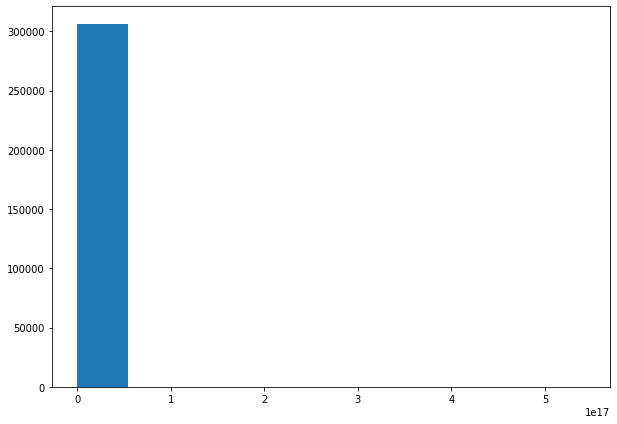

In [162]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(poss_score)
plt.show()

Clearly doesn't work, lets try using logistic regression to create a probability score

In [180]:
for_lr = pd.merge(df[['SK_ID_CURR', 'TARGET']], comb, on='SK_ID_CURR').drop('SK_ID_CURR', axis=1)
for_lr

,TARGET,RATIO_CREDIT_SUM_OVERDUE,RATIO_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,STATUS
0,1,0.0,30053.790,0,27.0
1,0,0.0,0.000,0,0.0
2,0,0.0,0.000,0,0.0
3,0,0.0,0.000,0,0.0
4,0,0.0,0.000,0,0.0
...,...,...,...,...,...
126931,0,0.0,101371.410,0,12.0
126932,0,0.0,30735.000,0,0.0
126933,0,0.0,0.000,0,0.0
126934,1,0.0,0.000,0,0.0


In [178]:
from Models import Logistic, Model
 
lr = Model('Logistic')
Y = for_lr['TARGET']
X = for_lr.drop('TARGET', axis=1)
B = lr.fit(X.to_numpy(), Y.to_numpy())
probs = lr.predict(X.to_numpy(), B, True, .5)

Eta: 0.1; Iterations: 4
Eta: 0.01; Iterations: 4
Eta: 0.001; Iterations: 4
Eta: 0.0001; Iterations: 4
Eta: 1e-05; Iterations: 4
Eta: 1e-06; Iterations: 4
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
